K-Means

In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm

In [2]:
sql = '''
SELECT *  FROM `eth-tokens.alldata.clean_avg` LIMIT 5000
'''

df = client.query(sql).to_dataframe()

In [3]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [297]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [298]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [299]:
#get centroids
c = cl.cluster_centers_
#transform back to real numbers
medoids = scale.inverse_transform(pca.inverse_transform(c))
pd.DataFrame(medoids, columns = data.columns)

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_eth_sent,monthly_usd_sent,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns
0,8.584970,11.564997,50.685102,6.389136,1.912328e+04,1763.427118,55.654707,6.011355,2.066503e+04,1.833455e+03,...,15.367924,4.235835e+03,17.596922,4.794294e+03,3.351388e-02,2.738659e-01,3.302664e+05,3.266784e+05,338913.293525,3.382735e+05
1,25.615156,42.648341,141.382804,5.455985,6.325188e+04,2412.820961,154.399609,7.011530,6.752807e+04,2.806508e+03,...,12.654539,5.664059e+03,13.421530,6.066024e+03,8.320951e-02,3.415800e+01,9.242428e+05,1.295546e+06,765906.258197,1.254089e+06
2,28.250000,33.166667,9723.302680,389.779996,4.238680e+06,152085.587429,8210.394802,420.533290,3.380167e+06,1.915194e+05,...,965.909851,3.830800e+05,874.483456,3.361764e+05,7.542578e-15,2.932765e-12,1.001371e+06,1.445606e+06,673216.817529,1.377024e+06
3,19.666667,12.666667,23940.095369,1764.657422,1.463550e+07,758436.178875,24859.317667,3213.028092,1.396037e+07,1.458694e+06,...,3599.626555,1.585830e+06,3820.244607,1.591886e+06,4.073131e-15,1.980816e-11,1.768100e+05,4.143434e+05,716717.240513,1.729759e+06


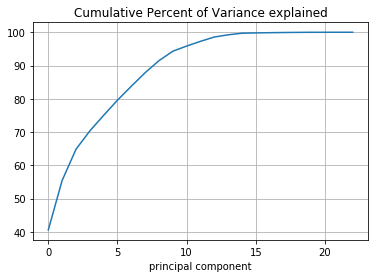

In [300]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

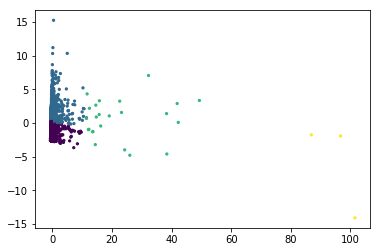

In [301]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_, s=5)

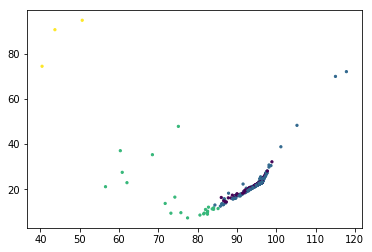

In [302]:
#plot in cluster distance space
r = cl.transform(results)
plt.scatter(r[:,3],r[:,2],c=cl.labels_, s=5)

In [303]:
#elbow method


In [304]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [2, 3,4,5,6,7,8,9,10,12,15,20,25, 40]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


Text(0.5,1,'Calinski Harabaz Scores')

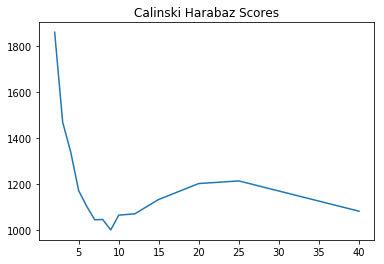

In [305]:
plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

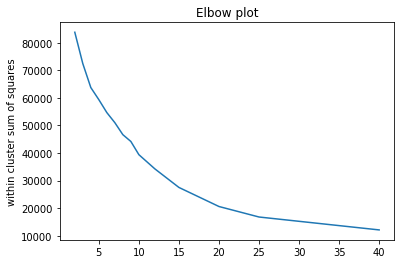

In [306]:
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [307]:
#outlier removal



def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [308]:
thresholds = np.linspace(.5,3, 15)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

Text(0.5,1,'Calinski Harabaz Scores as std threshold changes')

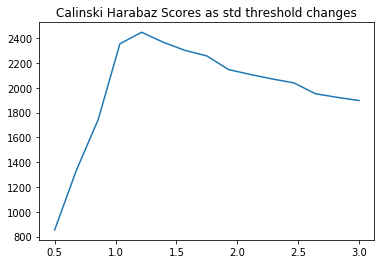

In [309]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [310]:
#empirical best threshold 1.25 stdev
newresults, labels = remove_outliers(results, cl,1.25)

(-15, 10)

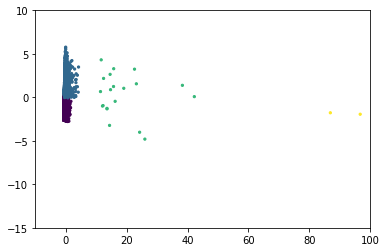

In [313]:
plt.scatter(newresults[:,0],newresults[:,1],c=labels, s=5)
plt.xlim(-10,100)
plt.ylim(-15,10)

(-15, 10)

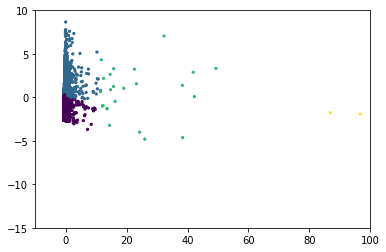

In [314]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_, s=5)
plt.xlim(-10,100)
plt.ylim(-15,10)

In [315]:
#recluster after changes
newcl = KMeans(num_clusters).fit(newresults)

(-15, 10)

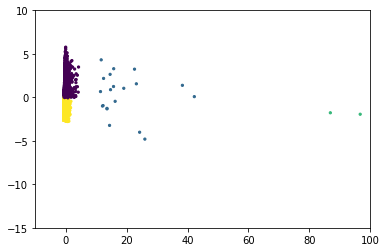

In [316]:
plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_, s=5)
plt.xlim(-10,100)
plt.ylim(-15,10)